### Conf and init

In [9]:
## Standard libraries
import os
import math
import numpy as np
import pandas as pd
from collections import defaultdict

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda")
print("Using device", device)

Using device cuda


<Figure size 640x480 with 0 Axes>

In [10]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

# Seting DIR
DIR = "/content/drive/My Drive/Project CVLAB/Part 2"
os.makedirs(DIR, exist_ok=True)

Mounted at /content/drive


In [11]:
def scale(sample):
    return 2 * sample - 1

# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(), scale])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)

train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True,  drop_last=True)
val_loader   = data.DataLoader(val_set,   batch_size=128, shuffle=False, drop_last=True)
test_loader  = data.DataLoader(test_set,  batch_size=128, shuffle=False, drop_last=True)

print('Train size:', len(train_loader.dataset))
print('Validation size:', len(val_loader.dataset))
print('Test size:', len(test_loader.dataset))

Train size: 50000
Validation size: 10000
Test size: 10000


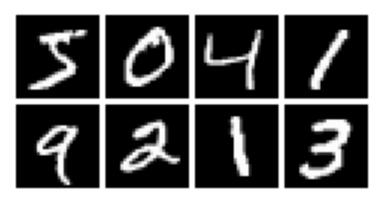

In [12]:
def show_tensor_image(img):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(img))


def show_imgs(imgs, nrows=1):
    ncols = len(imgs) // nrows

    imgs = torch.stack(imgs) if isinstance(imgs, list) else imgs        # T, img, ch, size, size or img, ch, size, size

    imgs = imgs.unsqueeze(0) if imgs.ndim == 4 else imgs                # T, img, ch, size, size
    imgs = imgs.transpose(1, 0)                                         # img, T, ch, size, size
    imgs = imgs.reshape((-1,) + imgs.shape[2:])                         # img * T, ch, size, size

    plt.figure(figsize=(ncols * 1.2, nrows * 1.2))
    grid = torchvision.utils.make_grid(imgs.cpu(), nrow=ncols, pad_value=128)
    show_tensor_image(grid.detach().cpu())

    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train_dataset[i][0] for i in range(8)], nrows=2)

### train model

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleMNISTFeatureNet(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 96, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(96, 192, 3, 1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(192, 384, 3, 1, padding=1),
            nn.ReLU()
        )
        self.flatten = nn.Flatten()
        self.fc_feat = nn.Linear(384*5*5, latent_dim)
        self.fc_out  = nn.Linear(latent_dim, 10)

    def forward(self, x):
        x = self.conv(x)
        x = self.flatten(x)
        feat = F.relu(self.fc_feat(x))
        out = self.fc_out(feat)
        return out, feat


class MNISTDecoder(nn.Module):
    def __init__(self, latent_dim=128):
        super().__init__()
        self.fc = nn.Linear(latent_dim, 384*5*5)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(384, 192, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(192, 96, 4, 2, 1),
            nn.ReLU(),
            nn.ConvTranspose2d(96, 48, 4, 2, 1),
            nn.ReLU(),
            nn.Conv2d(48, 1, 13, 1, 0),
            nn.Sigmoid()
        )

    def forward(self, z):
        x = self.fc(z)
        x = x.view(-1, 384, 5, 5)
        x_recon = self.decoder(x)
        return x_recon



In [14]:
def train_feature_net(net, decoder, train_loader, epochs, lr, device, alpha=1.0, beta=1.0):
    optimizer = torch.optim.Adam(list(net.parameters()) + list(decoder.parameters()), lr=lr)
    cls_criterion = nn.CrossEntropyLoss()
    recon_criterion = nn.MSELoss()

    net.train()
    decoder.train()

    for epoch in range(epochs):
        running_loss = 0.0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=True)
        for imgs, labels in pbar:
            imgs, labels = imgs.to(device), labels.to(device)

            optimizer.zero_grad()
            logits, feat = net(imgs)          # forward through encoder+classifier
            recon = decoder(feat)             # decode from latent

            cls_loss = cls_criterion(logits, labels)
            recon_loss = recon_criterion(recon, imgs)
            loss = alpha * cls_loss + beta * recon_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * imgs.size(0)
            pbar.set_postfix({
                "cls_loss": cls_loss.item(),
                "recon_loss": recon_loss.item(),
                "avg_loss": running_loss / ((pbar.n + 1) * train_loader.batch_size)
            })

        print(f"[Epoch {epoch+1}] Avg Loss: {running_loss/len(train_loader.dataset):.4f}")

    net.eval()
    decoder.eval()


In [15]:
netEncoder = SimpleMNISTFeatureNet().to(device)
decoder = MNISTDecoder().to(device)
train_feature_net(netEncoder, decoder, train_loader, epochs=12, lr=1e-3, device=device)

Epoch 1/12:   0%|          | 0/390 [00:00<?, ?it/s]

[Epoch 1] Avg Loss: 1.0935


Epoch 2/12:   0%|          | 0/390 [00:00<?, ?it/s]

[Epoch 2] Avg Loss: 0.9645


Epoch 3/12:   0%|          | 0/390 [00:00<?, ?it/s]

[Epoch 3] Avg Loss: 0.9522


Epoch 4/12:   0%|          | 0/390 [00:00<?, ?it/s]

[Epoch 4] Avg Loss: 0.9418


Epoch 5/12:   0%|          | 0/390 [00:00<?, ?it/s]

[Epoch 5] Avg Loss: 0.9418


Epoch 6/12:   0%|          | 0/390 [00:00<?, ?it/s]

[Epoch 6] Avg Loss: 0.9359


Epoch 7/12:   0%|          | 0/390 [00:00<?, ?it/s]

[Epoch 7] Avg Loss: 0.9370


Epoch 8/12:   0%|          | 0/390 [00:00<?, ?it/s]

[Epoch 8] Avg Loss: 0.9328


Epoch 9/12:   0%|          | 0/390 [00:00<?, ?it/s]

[Epoch 9] Avg Loss: 0.9334


Epoch 10/12:   0%|          | 0/390 [00:00<?, ?it/s]

[Epoch 10] Avg Loss: 0.9327


Epoch 11/12:   0%|          | 0/390 [00:00<?, ?it/s]

[Epoch 11] Avg Loss: 0.9310


Epoch 12/12:   0%|          | 0/390 [00:00<?, ?it/s]

[Epoch 12] Avg Loss: 0.9293


In [17]:
torch.save(netEncoder.state_dict(), os.path.join(DIR, f"EncoderNEW.pth"))